In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import scipy.stats as stats

import tensorflow as tf
from tensorflow import keras
from keras.api._v2 import keras
from keras.layers import Dense,Flatten, Dropout
from keras.layers import Conv2D, SimpleRNN, GRU, LSTM
import keras_tuner as kt

In [14]:
dataset = pd.read_csv("sdata.csv")
dataset['label'].value_counts()

Positive    24520
Negative    20938
Name: label, dtype: int64

In [15]:
def plot_act(activity, data, col):
    fig, (ax0,ax1,ax2) = plt.subplots(nrows = 3, figsize = (15,7), sharex = True)
    plot_axis(ax0,data['timestamp'],data['{}_x'.format(col)],'X-axis')
    plot_axis(ax1,data['timestamp'],data['{}_y'.format(col)],'Y-axis')
    plot_axis(ax2,data['timestamp'],data['{}_z'.format(col)],'Z-axis')
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(top = 0.90)
    plt.show()

def plot_axis(ax,x,y,title):
    ax.plot(x,y,'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x) , max(x)])
    ax.grid(True)

Running accel


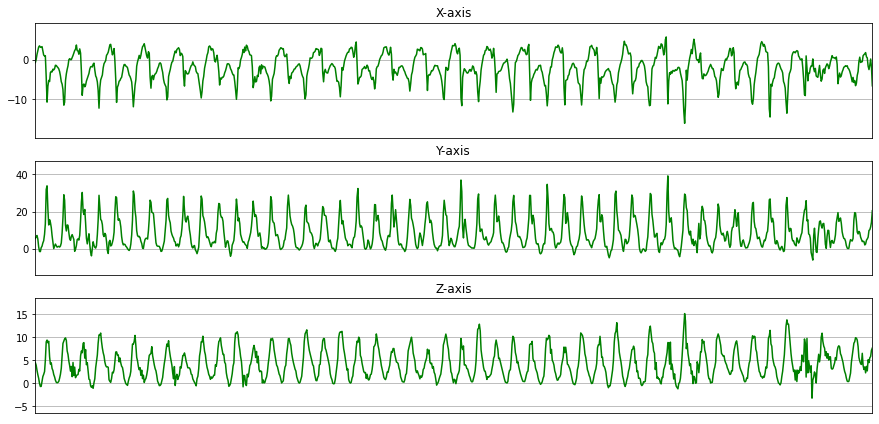

Running gyro


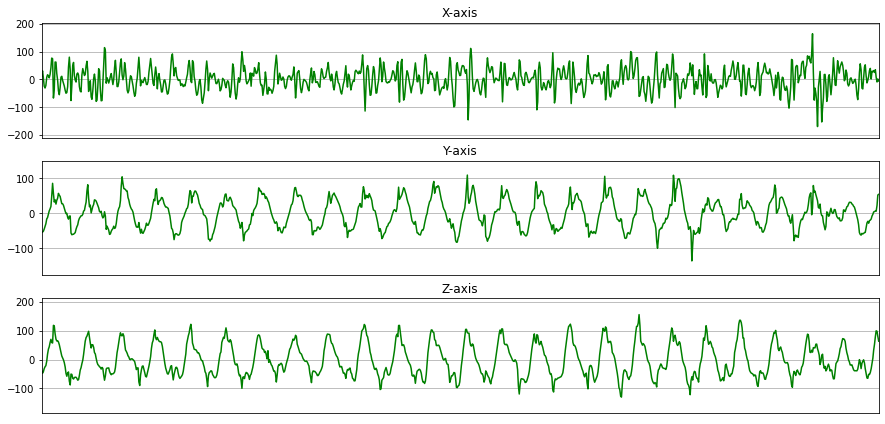

Running euler


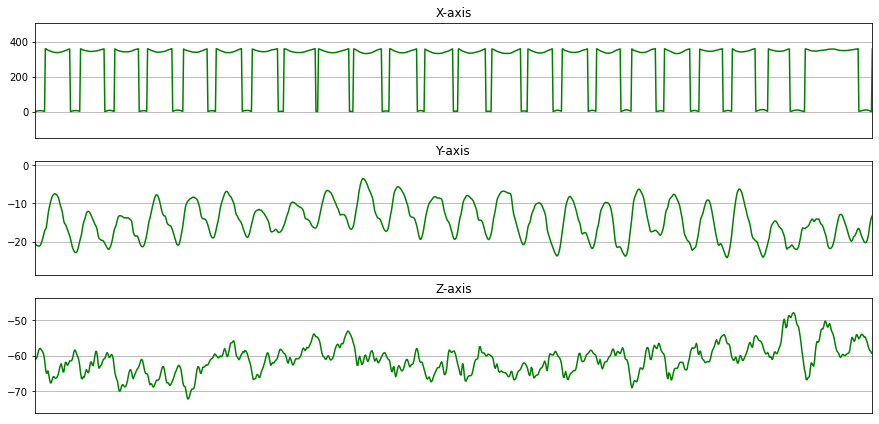

Running linear


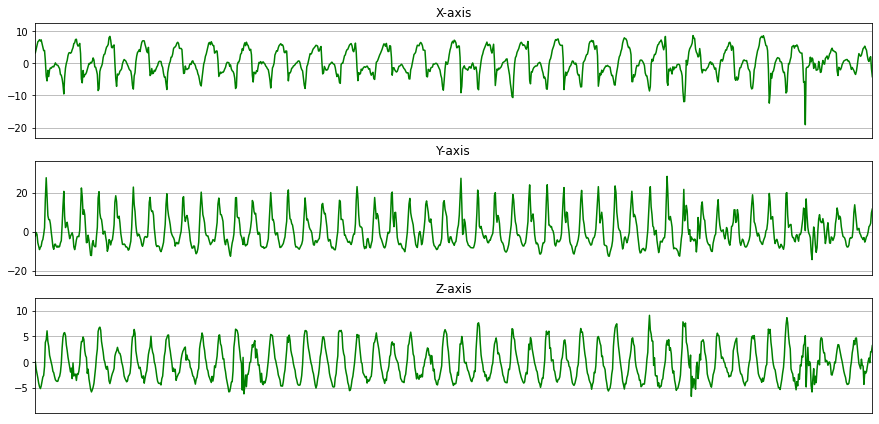

RunningGesture accel


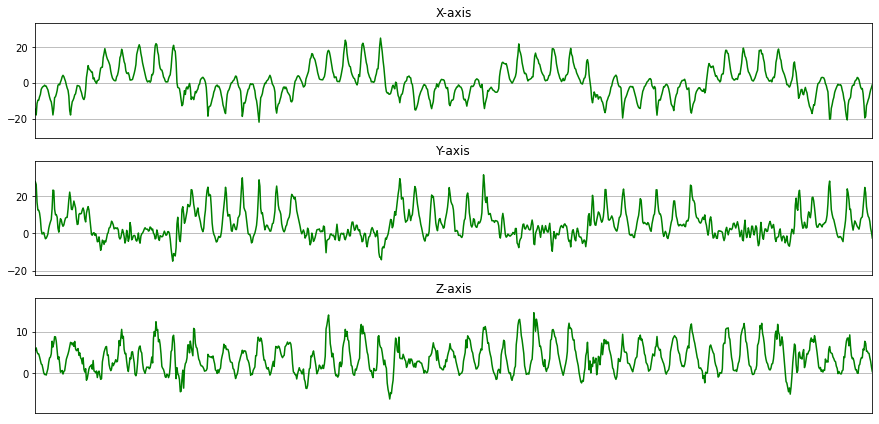

RunningGesture gyro


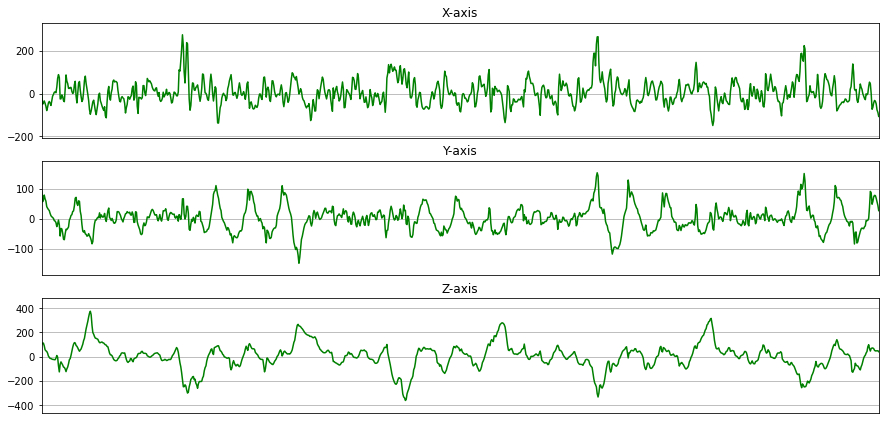

RunningGesture euler


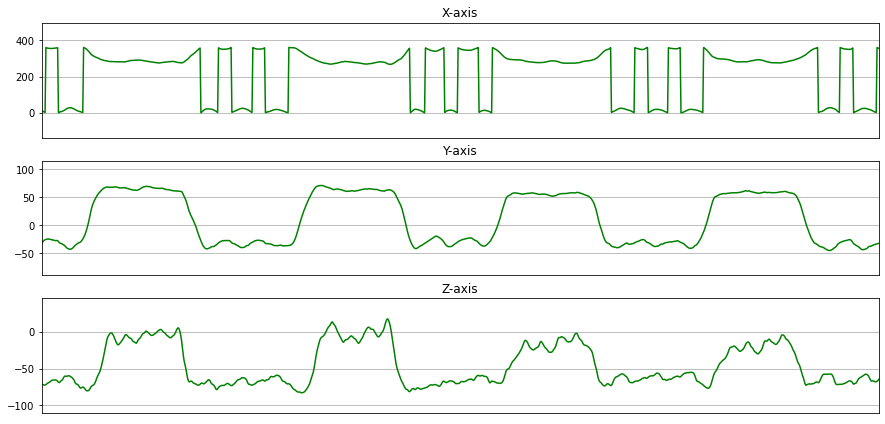

RunningGesture linear


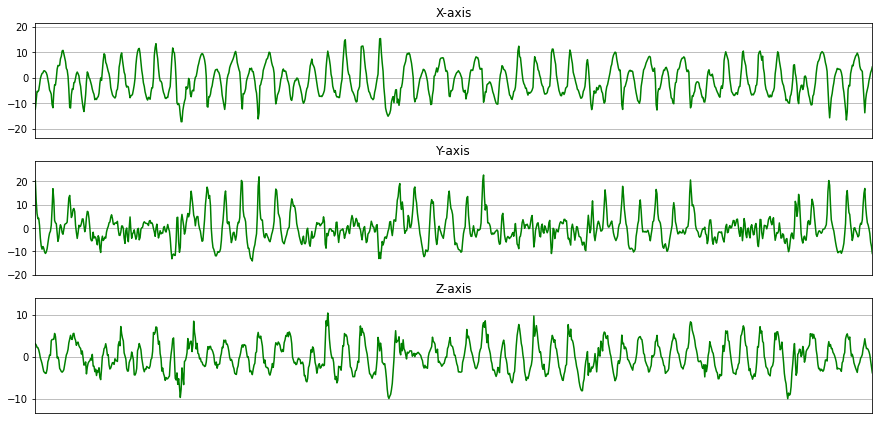

In [16]:
actions = ["Running", "RunningGesture"]
cols = ["accel", "gyro", "euler", "linear"]
for action in actions:
    for col in cols:
        print(action, col)
        plot_act(action, dataset[dataset["activity"] == action][2000:3000], col)

In [17]:
label = LabelEncoder()
dataset['encoded_label'] = label.fit_transform(dataset['label'])

y = dataset['encoded_label']
X = dataset[['accel_x','accel_y','accel_z','gyro_x','gyro_y','gyro_z', 'euler_x','euler_y', 'euler_z', 'linear_x','linear_y','linear_z']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
dataset_scaled = pd.DataFrame(X_scaled, columns = ['accel_x','accel_y','accel_z','gyro_x','gyro_y','gyro_z', 'euler_x','euler_y', 'euler_z', 'linear_x','linear_y','linear_z'])
dataset_scaled['label'] = y.values

In [18]:
freq = 80
window = 5
frameSize = freq*window # 80Hz * 5sec
overlapping = int(0.1*freq*window) # 50 percent overlapping

def get_frames(data,frame_size,overlap):
    num_features = 12
    frames = []
    labels = []

    for i in range(0,len(data) - frame_size, overlap):
        accel_x = data['accel_x'].values[i:i + frame_size]
        accel_y = data['accel_y'].values[i:i + frame_size]
        accel_z = data['accel_z'].values[i:i + frame_size]
        gyro_x = data['gyro_x'].values[i:i + frame_size]
        gyro_y = data['gyro_y'].values[i:i + frame_size]
        gyro_z = data['gyro_z'].values[i:i + frame_size]
        euler_x = data['euler_x'].values[i:i + frame_size]
        euler_y = data['euler_y'].values[i:i + frame_size]
        euler_z = data['euler_z'].values[i:i + frame_size]
        linear_x = data['linear_x'].values[i:i + frame_size]
        linear_y = data['linear_y'].values[i:i + frame_size]
        linear_z = data['linear_z'].values[i:i + frame_size]

        label = stats.mode(dataset['label'][i:i + frame_size])[0][0]
        frames.append([accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, euler_x, euler_y, euler_z,linear_x, linear_y ,linear_z])
        labels.append(label)

    return frames,labels

In [19]:
cnn_reshape = True

X,y = get_frames(dataset_scaled, frameSize, overlapping)
X = np.asarray(X).reshape(-1,frameSize,12)
y = np.asarray(y)
a = LabelEncoder()
y = a.fit_transform(y)
X_train,X_test,y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 1, stratify = y)

if cnn_reshape:
    X_train = X_train.reshape(X_train.shape[0],400,12,1)
    X_test = X_test.reshape(X_test.shape[0],400,12,1)

X_train.shape

(901, 400, 12, 1)

Models and parameter tuning

In [20]:
# Model structures and target hyperparameters are defined here

def cnn_builder(hp):
    model = keras.Sequential()

    # Conv layer 1
    hp_filters_1 = hp.Int('l1_filter', min_value=16, max_value=64, step=16)
    hp_dp_1 = hp.Float('l1_dp', min_value=0.0, max_value=0.3, step=0.1)
    model.add(Conv2D(hp_filters_1,(2,2),activation='relu', input_shape=X_train[0].shape),)
    model.add(Dropout(hp_dp_1))

    # Conv layer 2
    hp_filters_2 = hp.Int('l2_filter', min_value=32, max_value=128, step=32)
    hp_dp_2 = hp.Float('l2_dp', min_value=0.0, max_value=0.3, step=0.1)
    model.add(Conv2D(hp_filters_2,(2,2),activation='relu'))
    model.add(Dropout(hp_dp_2))
    model.add(Flatten())

    # Layer 3
    hp_units_3 = hp.Int('l3_units', min_value=32, max_value=128, step=32)
    model.add(Dense(hp_units_3, activation='relu'))
    model.add(Dropout(0.5))

    # Output
    model.add(Dense(2, activation='softmax'))

    # Compile
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

def rnn_builder(hp):
    model = keras.Sequential()

    # RNN layer 1
    hp_layer_1 = hp.Int('l1_units', min_value=16, max_value=64, step=16)
    hp_dp_1 = hp.Float('l1_dp', min_value=0.0, max_value=0.3, step=0.1)
    model.add(SimpleRNN(hp_layer_1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp_dp_1))
    # RNN layer 2
    hp_layer_2 = hp.Int('l2_units', min_value=16, max_value=64, step=16)
    hp_dp_2 = hp.Float('l2_dp', min_value=0.0, max_value=0.3, step=0.1)
    model.add(SimpleRNN(hp_layer_2))
    model.add(Dropout(hp_dp_2))

    # Layer 3
    hp_units_3 = hp.Int('l3_units', min_value=16, max_value=64, step=16)
    model.add(Dense(hp_units_3, activation='relu'))
    model.add(Dropout(0.5))

    # Output
    model.add(Dense(2, activation='softmax'))

    # Compile
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

def lstm_builder(hp):
    model = keras.Sequential()

    # LSTM layer 1
    hp_layer_1 = hp.Int('l1_units', min_value=16, max_value=64, step=16)
    hp_dp_1 = hp.Float('l1_dp', min_value=0.0, max_value=0.3, step=0.1)
    model.add(LSTM(hp_layer_1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp_dp_1))
    # LSTM layer 2
    hp_layer_2 = hp.Int('l2_units', min_value=16, max_value=64, step=16)
    hp_dp_2 = hp.Float('l2_dp', min_value=0.0, max_value=0.3, step=0.1)
    model.add(LSTM(hp_layer_2))
    model.add(Dropout(hp_dp_2))

    # Layer 3
    hp_units_3 = hp.Int('l3_units', min_value=16, max_value=64, step=16)
    model.add(Dense(hp_units_3, activation='relu'))
    model.add(Dropout(0.5))

    # Output
    model.add(Dense(2, activation='softmax'))

    # Compile
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

def gru_builder(hp):
    model = keras.Sequential()

    # GRU layer 1
    hp_layer_1 = hp.Int('l1_units', min_value=16, max_value=64, step=16)
    hp_dp_1 = hp.Float('l1_dp', min_value=0.0, max_value=0.3, step=0.1)
    model.add(GRU(hp_layer_1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp_dp_1))
    # GRU layer 2
    hp_layer_2 = hp.Int('l2_units', min_value=16, max_value=64, step=16)
    hp_dp_2 = hp.Float('l2_dp', min_value=0.0, max_value=0.3, step=0.1)
    model.add(GRU(hp_layer_2))
    model.add(Dropout(hp_dp_2))

    # Layer 3
    hp_units_3 = hp.Int('l3_units', min_value=16, max_value=64, step=16)
    model.add(Dense(hp_units_3, activation='relu'))
    model.add(Dropout(0.5))

    # Output
    model.add(Dense(2, activation='softmax'))

    # Compile
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model



In [21]:
# Modify function here
tuner = kt.Hyperband(cnn_builder, objective='val_accuracy', max_epochs=20)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=20, validation_split=0.2)
#best_hp=tuner.get_best_hyperparameters()[0]

# Build the model with the optimal hyperparameters
#h_model = tuner.hypermodel.build(best_hp)

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [22]:
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)

# Build the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hp)
history = h_model.fit(X_train, y_train, epochs=30, validation_split=0.2)

{'l1_units': 48, 'l1_dp': 0.2, 'l2_units': 64, 'l2_dp': 0.0, 'l3_units': 32, 'learning_rate': 0.01, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0019'}
Epoch 1/30
23/23 [==============================] - 2s 71ms/step - loss: 2.4432 - accuracy: 0.8611 - val_loss: 0.1010 - val_accuracy: 0.9834
Epoch 2/30
23/23 [==============================] - 1s 64ms/step - loss: 0.0777 - accuracy: 0.9792 - val_loss: 0.0282 - val_accuracy: 0.9890
Epoch 3/30
23/23 [==============================] - 1s 65ms/step - loss: 0.0421 - accuracy: 0.9792 - val_loss: 0.0359 - val_accuracy: 0.9834
Epoch 4/30
23/23 [==============================] - 1s 63ms/step - loss: 0.0285 - accuracy: 0.9875 - val_loss: 0.0198 - val_accuracy: 0.9834
Epoch 5/30
23/23 [==============================] - 1s 63ms/step - loss: 0.0251 - accuracy: 0.9889 - val_loss: 0.0157 - val_accuracy: 0.9890
Epoch 6/30
23/23 [==============================] - 1s 65ms/step - loss: 0.0238 - acc

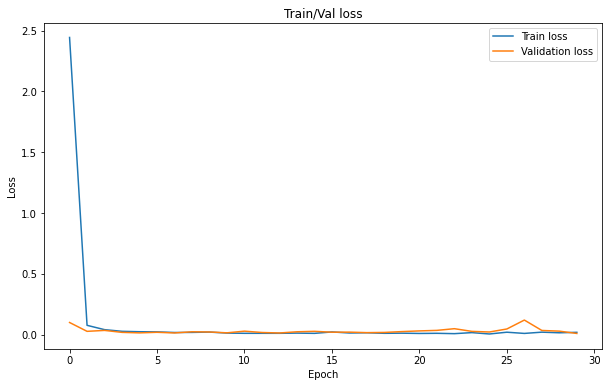

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Train/Val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train loss", "Validation loss"], loc="upper right")

In [24]:
y_pred = np.argmax(h_model.predict(X_test), axis=1)

mse = np.mean(np.square(y_pred - y_test))
mat = confusion_matrix(y_test, y_pred)
score = f1_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
print(mse)
print(mat)
print(score)
print(prec, rec)
print(best_hp.values)

0.01327433628318584
[[104   0]
 [  3 119]]
0.9875518672199171
1.0 0.9754098360655737
{'l1_units': 48, 'l1_dp': 0.2, 'l2_units': 64, 'l2_dp': 0.0, 'l3_units': 32, 'learning_rate': 0.01, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0019', 'l1_filter': 16, 'l2_filter': 32}
